# SocioPatterns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import igraph as ig
import dionysus as d

In [3]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = 10, 6

In [4]:
%load_ext autoreload
%autoreload 2

## Data import

In [5]:
import os

datadir = "data/sociopatterns/infectious/INFECTIOUS_cumulative_daily_networks/"
files = [os.path.join(datadir, f) for f in os.listdir(datadir)]
gs = []
for f in files:
    gs.append(ig.read(f))

In [6]:
gs[0].summary()

'IGRAPH U-W- 242 1092 -- \n+ attr: id (v), weight (e)'

In [7]:
len(gs)

69

## Persistent homology

In [8]:
from filtration import wrcf

In [9]:
def get_diagram(graph, weight="weight"):
    filt = wrcf(graph, weight=weight)
    pers = d.homology_persistence(filt)
    return(d.init_diagrams(pers, filt))

In [10]:
%%time
dgms = [get_diagram(g) for g in gs]

CPU times: user 1min 36s, sys: 128 ms, total: 1min 36s
Wall time: 1min 36s


In [9]:
from dask.distributed import Client

In [10]:
with Client() as client:
    dgms = client.map(get_diagram, gs)
    dgms = client.gather(dgms)

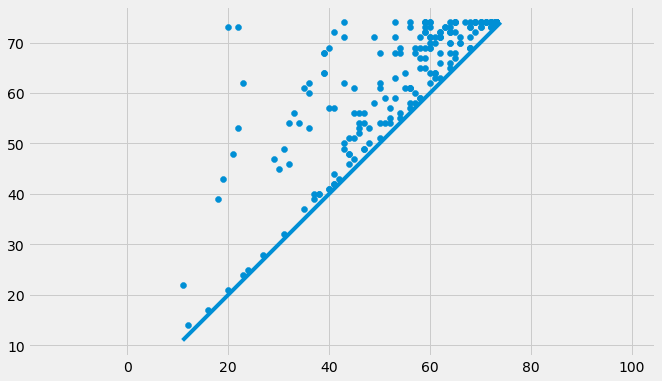

In [11]:
d.plot.plot_diagram(dgms[0][1])

## Sliced Wasserstein Kernel

In [65]:
from sliced_wasserstein import SW_approx

In [90]:
SW_approx(dgms[0][1], dgms[1][1], 10)

5108.143167337765

In [91]:
gram = np.array([[SW_approx(dgms[i][1], dgms[j][1], 10) for i in range(len(dgms))] for j in range(len(dgms))])
gram

array([[    0.        ,  5108.14316734,  9472.53497695, ...,
         1776.37863582,  5490.20107947,  3987.46566694],
       [ 5108.14316734,     0.        , 14124.45002927, ...,
         3872.70359252,  1866.27573268,  1759.4397636 ],
       [ 9472.53497695, 14124.45002927,     0.        , ...,
        10464.74527685, 14731.10894512, 12627.65440869],
       ...,
       [ 1776.37863582,  3872.70359252, 10464.74527685, ...,
            0.        ,  4448.29923611,  2525.56709237],
       [ 5490.20107947,  1866.27573268, 14731.10894512, ...,
         4448.29923611,     0.        ,  2883.85881363],
       [ 3987.46566694,  1759.4397636 , 12627.65440869, ...,
         2525.56709237,  2883.85881363,     0.        ]])

In [15]:
from sklearn_tda import SlicedWasserstein
from sliced_wasserstein import diagram_array

In [18]:
sw = SlicedWasserstein()
sw.fit_transform(diagram_array(dgms[0][1]).tolist())

IndexError: too many indices for array

## Kernel SVM

In [13]:
from sklearn.svm import OneClassSVM

In [14]:
clf = OneClassSVM(kernel='precomputed')

In [15]:
clf.fit(gram)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='precomputed', max_iter=-1, nu=0.5, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

In [27]:
(clf.predict(gram)+1)//2

array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1])

In [28]:
from sklearn.decomposition import KernelPCA

In [43]:
pca = KernelPCA(n_components=2, kernel='precomputed', remove_zero_eig=True)

In [41]:
pca.fit_transform(gram)

array([], shape=(69, 0), dtype=float64)